<a href="https://colab.research.google.com/github/Nandan0402/Handwritten-Digit-Detection/blob/main/Handwritten_digit_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Step 1: Loading data and training a small model... (wait ~1-2 minutes)
Epoch 1/3
422/422 - 37s - 87ms/step - accuracy: 0.9246 - loss: 0.2484 - val_accuracy: 0.9828 - val_loss: 0.0612
Epoch 2/3
422/422 - 37s - 87ms/step - accuracy: 0.9777 - loss: 0.0712 - val_accuracy: 0.9870 - val_loss: 0.0455
Epoch 3/3
422/422 - 37s - 87ms/step - accuracy: 0.9852 - loss: 0.0514 - val_accuracy: 0.9880 - val_loss: 0.0432
Training finished. Test accuracy: 0.9874
Step 2: Upload a PNG/JPG of a handwritten digit.


Saving 5.jpg to 5.jpg

Uploaded file: 5.jpg


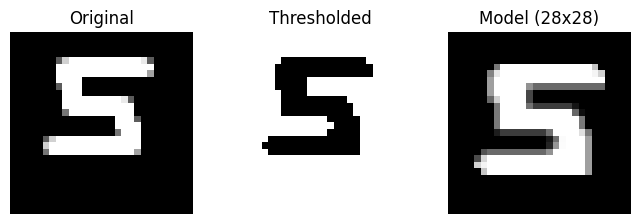

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
Prediction (CNN): 5 (confidence: 1.00)
OCR result: (no text detected)


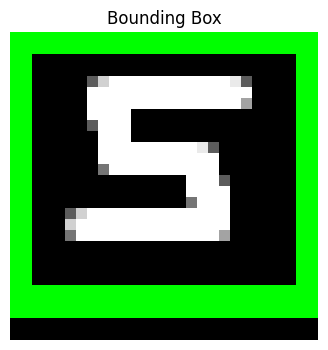


Done.


In [ ]:
!apt-get update -qq && apt-get install -y -qq tesseract-ocr
!pip install -q pytesseract opencv-python-headless pillow tensorflow matplotlib

import tensorflow as tf
import numpy as np
import cv2
from google.colab import files
import matplotlib.pyplot as plt
import pytesseract
from PIL import Image

print("Step 1: Loading data and training a small model... (wait ~1-2 minutes)")

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train / 255.0
x_test = x_test / 255.0
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(28,28,1)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=3, batch_size=128, validation_split=0.1, verbose=2)

loss, acc = model.evaluate(x_test, y_test, verbose=0)
print("Training finished. Test accuracy: {:.4f}".format(acc))

def preprocess_image_for_model(img_gray):
    blur = cv2.GaussianBlur(img_gray, (5,5), 0)
    _, th = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    if np.mean(th) < 127:
        th = 255 - th
    coords = cv2.findNonZero(255 - th)
    if coords is not None:
        x, y, w, h = cv2.boundingRect(coords)
        digit = th[y:y+h, x:x+w]
    else:
        digit = th
        x, y, w, h = 0, 0, th.shape[1], th.shape[0]
    h_d, w_d = digit.shape
    if h_d == 0 or w_d == 0:
        digit_resized = cv2.resize(th, (20,20))
    else:
        if h_d > w_d:
            new_h = 20
            new_w = max(1, int(w_d * (20.0 / h_d)))
        else:
            new_w = 20
            new_h = max(1, int(h_d * (20.0 / w_d)))
        digit_resized = cv2.resize(digit, (new_w, new_h))
    canvas = np.ones((28,28), dtype=np.uint8) * 255
    x_off = (28 - digit_resized.shape[1]) // 2
    y_off = (28 - digit_resized.shape[0]) // 2
    canvas[y_off:y_off+digit_resized.shape[0], x_off:x_off+digit_resized.shape[1]] = digit_resized
    canvas = 255 - canvas
    canvas = canvas.astype('float32') / 255.0
    canvas = np.expand_dims(canvas, axis=-1)
    return canvas, (x, y, w, h), th

print("Step 2: Upload a PNG/JPG of a handwritten digit.")
uploaded = files.upload()

for fn in uploaded.keys():
    print("\nUploaded file:", fn)
    img = cv2.imdecode(np.frombuffer(uploaded[fn], np.uint8), cv2.IMREAD_GRAYSCALE)
    if img is None:
        print("Could not read the image. Try another file.")
        continue

    model_ready, bbox, th_full = preprocess_image_for_model(img)
    x, y, w, h = bbox
    input_batch = np.expand_dims(model_ready, axis=0)

    plt.figure(figsize=(8,4))
    plt.subplot(1,3,1); plt.title("Original"); plt.axis('off'); plt.imshow(img, cmap='gray')
    plt.subplot(1,3,2); plt.title("Thresholded"); plt.axis('off'); plt.imshow(th_full, cmap='gray')
    plt.subplot(1,3,3); plt.title("Model (28x28)"); plt.axis('off'); plt.imshow(model_ready.squeeze(), cmap='gray')
    plt.show()

    preds = model.predict(input_batch)
    digit = np.argmax(preds[0])
    conf = float(np.max(preds[0]))
    print(f"Prediction (CNN): {digit} (confidence: {conf:.2f})")

    pad = 5
    x1, y1 = max(0, x - pad), max(0, y - pad)
    x2, y2 = min(th_full.shape[1], x + w + pad), min(th_full.shape[0], y + h + pad)
    region = th_full[y1:y2, x1:x2]
    if region.size == 0:
        region = th_full

    ocr_pil = Image.fromarray(region)
    ocr_result = pytesseract.image_to_string(ocr_pil, config='--psm 7 -c tessedit_char_whitelist=0123456789').strip()

    if ocr_result == "":
        print("OCR result: (no text detected)")
    else:
        print(f"OCR result: {ocr_result}")

    vis = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    cv2.rectangle(vis, (x1, y1), (x2, y2), (0,255,0), 2)
    plt.figure(figsize=(4,4)); plt.title("Bounding Box"); plt.axis('off')
    plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB)); plt.show()

print("\nDone.")


In [ ]:
print("Step 1: Loading data and training a small model... (wait ~1-2 minutes)")

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train / 255.0
x_test = x_test / 255.0

x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

Step 1: Loading data and training a small model... (wait ~1-2 minutes)


In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(28,28,1)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
model.fit(x_train, y_train, epochs=6, batch_size=128, validation_split=0.1, verbose=2)

loss, acc = model.evaluate(x_test, y_test, verbose=0)
print("Training finished. Test accuracy: {}".format(acc))

Epoch 1/6
422/422 - 48s - 115ms/step - accuracy: 0.9216 - loss: 0.2610 - val_accuracy: 0.9835 - val_loss: 0.0594
Epoch 2/6
422/422 - 76s - 179ms/step - accuracy: 0.9781 - loss: 0.0704 - val_accuracy: 0.9867 - val_loss: 0.0438
Epoch 3/6
422/422 - 40s - 94ms/step - accuracy: 0.9842 - loss: 0.0499 - val_accuracy: 0.9878 - val_loss: 0.0453
Epoch 4/6
422/422 - 41s - 96ms/step - accuracy: 0.9875 - loss: 0.0401 - val_accuracy: 0.9897 - val_loss: 0.0383
Epoch 5/6
422/422 - 37s - 87ms/step - accuracy: 0.9900 - loss: 0.0335 - val_accuracy: 0.9905 - val_loss: 0.0346
Epoch 6/6
422/422 - 41s - 97ms/step - accuracy: 0.9912 - loss: 0.0278 - val_accuracy: 0.9903 - val_loss: 0.0349
Training finished. Test accuracy: 0.9891999959945679


In [ ]:
def preprocess_image_for_model(img_gray):

    blur = cv2.GaussianBlur(img_gray, (5,5), 0)
    _, th = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    if np.mean(th) < 127:
        th = 255 - th

    coords = cv2.findNonZero(255 - th)
    if coords is not None:
        x, y, w, h = cv2.boundingRect(coords)
        digit = th[y:y+h, x:x+w]
    else:
        digit = th

    h, w = digit.shape
    if h == 0 or w == 0:
        digit_resized = cv2.resize(th, (20,20))
    else:
        if h > w:
            new_h = 20
            new_w = max(1, int(w * (20.0 / h)))
        else:
            new_w = 20
            new_h = max(1, int(h * (20.0 / w)))
        digit_resized = cv2.resize(digit, (new_w, new_h))

    canvas = np.ones((28,28), dtype=np.uint8) * 255
    x_off = (28 - digit_resized.shape[1]) // 2
    y_off = (28 - digit_resized.shape[0]) // 2
    canvas[y_off:y_off+digit_resized.shape[0], x_off:x_off+digit_resized.shape[1]] = digit_resized

    canvas = 255 - canvas

    canvas = canvas.astype('float32') / 255.0
    canvas = np.expand_dims(canvas, axis=-1)  # (28,28,1)
    return canvas

In [ ]:
print("Step 2: Upload a PNG/JPG (one handwritten digit, black pen on white paper works best).")
uploaded = files.upload()

for fn in uploaded.keys():
    print("\n Uploaded file:", fn)

    img = cv2.imdecode(np.frombuffer(uploaded[fn], np.uint8), cv2.IMREAD_GRAYSCALE)
    if img is None:
        print("Could not read the image. Try another file.")
        continue

Step 2: Upload a PNG/JPG (one handwritten digit, black pen on white paper works best).


In [ ]:
    model_ready = preprocess_image_for_model(img)
    input_batch = np.expand_dims(model_ready, axis=0)

    plt.figure(figsize=(6,3))
    plt.subplot(1,2,1); plt.title("Original (grayscale)"); plt.axis('off')
    plt.imshow(img, cmap='gray')
    plt.subplot(1,2,2); plt.title("Model sees (28x28)"); plt.axis('off')
    plt.imshow(model_ready.squeeze(), cmap='gray')
    plt.show()

In [ ]:
    preds = model.predict(input_batch)
    digit = np.argmax(preds[0])
    conf = float(np.max(preds[0]))

    print(f"Prediction:{digit}(confidence:{conf:.2f})")

In [ ]:
    pad = 5
    x1 = max(0, x - pad)
    y1 = max(0, y - pad)
    x2 = min(th_full.shape[1], x + w + pad)
    y2 = min(th_full.shape[0], y + h + pad)
    region = th_full[y1:y2, x1:x2]